## Pre-processing

In [79]:
import pandas as pd
import seaborn as sns

### Load csv file

In [80]:
stroke = pd.read_csv('data/healthcare-dataset-stroke-data.csv', encoding='unicode_escape')
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Check info of dataset

In [81]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [82]:
stroke.duplicated().sum()

0

In [83]:
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [84]:
# Filled missing bmi with average
stroke.fillna({"bmi":stroke['bmi'].mean().round(1)}, inplace=True)

In [85]:
stroke.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [86]:
# drop 1 patient with other for gender 
stroke['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [87]:
print(stroke[stroke['gender']=='Other'].index.values)

[3116]


In [88]:
stroke = stroke.drop(3116)
stroke['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

Use describe() to show details of data, make sure that there is nothing out of the ordinary in this data set

In [89]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,36513.985516,43.229986,0.097475,0.054022,106.140399,28.894774,0.048738
std,21162.008804,22.613575,0.296633,0.226084,45.285004,7.698235,0.215340
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## EDA

<AxesSubplot:xlabel='heart_disease', ylabel='age'>

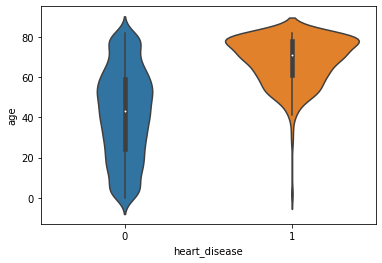

In [90]:
sns.violinplot(data=stroke, x='heart_disease', y='age')

heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.

Can see that people of older age have heart disease, meanwhile the amount of younger people without heart disease is greater.

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

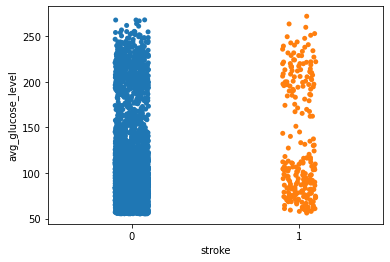

In [91]:
sns.stripplot(data=stroke, x='stroke', y='avg_glucose_level')

stroke: 1 if the patient had a stroke or 0 if not The amount of people with a glucose level around 150 seem to have the least amount of strokes

### Prepare data

In [92]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [93]:
stroke['gender'] = stroke['gender'].replace({'Male': 0, 'Female': 1})

In [94]:
replacement_dictionary = {'never smoked':0, 'Unknown':1, 'formerly smoked':2, 'smokes':3}
stroke['smoking_status'].replace(replacement_dictionary, inplace=True)

In [95]:
X = stroke.drop(columns=['stroke'])
y = stroke['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [96]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [97]:
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [98]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)

number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

In [99]:
preprocessor = make_column_transformer(number_tuple, category_tuple)

In [100]:
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Solving Imbalance

In [107]:
!pip3 install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [108]:
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler

ImportError: cannot import name '_is_arraylike_not_scalar' from 'sklearn.utils.validation' (c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py)

In [ ]:
under_sampler = RandomUnderSampler()
under_sample_pipe = make_sampler_pipeline(scaler, under_sampler)
X_train_under, y_train_under = under_sample_pipe.fit_resample(X_train_processed, y_train)

## Tune Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create and visualize our parameter grid
param_grid = {'max_depth': [1,2,3], 'min_samples_leaf': [3,15,20], 'min_samples_split': [2, 10, 100]}
pd.DataFrame(param_grid).T

,0,1,2
max_depth,1,2,3
min_samples_leaf,3,15,20
min_samples_split,2,10,100


In [ ]:
model = DecisionTreeClassifier()
param_grid = {'max_depth': [1,2,3], 'min_samples_leaf': [3,15,20], 'min_samples_split': [2, 10, 100]}

In [ ]:
dt_grid_search = GridSearchCV(model, param_grid)
dt_grid_search.fit(X_train_under, y_train_under)
y_pred = dt_grid_search.predict(X_test_processed)

In [ ]:
test_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
